#### Import the required libraries

In [1]:
import spacy
import numpy as np 
import nltk
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.family'] = 'serif'

#### List of keywords

In [3]:
job_title_keywords = [
    "aspiring human resources",
    "seeking human resources",
    "human resources professional",
    "full-stack software engineer",
    "engineering manager",
    "data scientist",
    "data analyst",
    "machine learning engineer",
    "product manager",
    "devops engineer",
    "frontend developer",
    "backend developer",
    "cloud architect",
    "business analyst",
    "UX designer",
    "AI researcher"
]

#### Choose the keywords required for a particular job

In [4]:
selected_keywords = job_title_keywords[1:3]  ### "human resources"

#### Perform lemmatization after removing common stopwords.

In [5]:
def lemmatize_and_remove_stopwords(text, nlp, stopwords):
    """
    Lemmatize the input text and remove stopwords.
    Args:
        text (str): Input text to process.
        nlp: spaCy language model.
        stopwords (set): Set of stopwords to remove.
    Returns:
        str: Lemmatized text with stopwords removed.
    """
    if pd.isnull(text):
        return None
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text.lower() not in stopwords]
    return " ".join(tokens)

#### Lemmatized keywords

In [6]:
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

lemmatized_keywords = [lemmatize_and_remove_stopwords(k, nlp, STOP_WORDS) for k in selected_keywords]
print(lemmatized_keywords)


['seek human resource', 'human resource professional']


#### Read the candidate data

In [12]:
candidate_data = pd.read_csv("potential-talents.csv")
candidate_data.head()

,id,job_title,location,connection,fit
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


#### Lemmatize the job titles after removing stopwords and converting to lower case

In [13]:
candidate_data['job_title_lemmatized'] = candidate_data['job_title'].apply(
    lambda x: lemmatize_and_remove_stopwords(str(x).lower(), nlp, STOP_WORDS) if pd.notnull(x) else None
)

In [14]:
candidate_data.head()

,id,job_title,location,connection,fit,job_title_lemmatized
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 c.t . bauer college business graduate ( m...
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik ( english program ...
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resource professional
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university


#### Keep a count of common abbreviations of *human resources* name in the job title

In [15]:
# Define common abbreviations for "human resources professional"
hr_abbreviations = [
    "hr", "h.r.", "human resources", "human resource", 
    "hr professional", "h.r. professional", "chro",
    "chief human resources officer", "hr manager", "hr director"
]

def is_hr_abbreviations(text):
    if pd.isnull(text):
        return False
    
    text_lower = str(text).lower().strip()
    
    # Check if any abbreviation is found
    return any(abbr in text_lower for abbr in hr_abbreviations)

# Apply to job_title column
candidate_data['hr_term'] = candidate_data['job_title'].apply(is_hr_abbreviations)

In [16]:
candidate_data.head()

,id,job_title,location,connection,fit,job_title_lemmatized,hr_term
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 c.t . bauer college business graduate ( m...,True
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik ( english program ...,False
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resource professional,True
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,False
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,False


#### Create functions for creating embeddings of words using *Word2Vec*, *Sentence_Transformers* and *GloVe* models.

In [17]:
from gensim.models import Word2Vec, KeyedVectors
from sentence_transformers import SentenceTransformer
import torch


def load_pretrained_word2vec():
    # Download from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
    # Or use Google's 300d model
    model_path = "D:/GoogleNews-vectors-negative300.bin"
    return KeyedVectors.load_word2vec_format(model_path, binary=True)

# Load once
pretrained_model = load_pretrained_word2vec()

def get_word2vec_embedding(phrase, model=pretrained_model):
    tokens = phrase.split()
    embeddings = []
    
    for word in tokens:
        if word in model:
            embeddings.append(model[word])
        # else:
        #     print(f"Warning: '{word}' not found in vocabulary")
    
    if embeddings:
        return np.array(embeddings)
    else:
        return np.array([]).reshape(0, model.vector_size)


model_name='all-MiniLM-L6-v2'
sentence_embedder = SentenceTransformer(model_name)
def get_sentence_transformer_embedding(phrase):
    embedding = sentence_embedder.encode(phrase)
    return embedding



# Load the model ONCE at module level
GLOVE_MODEL = None
vector_size = 300  # Default vector size, can be changed as needed

def load_glove_model(vector_size=300):
    global GLOVE_MODEL
    if GLOVE_MODEL is None:
        glove_path = f'D:/glove.6B.{vector_size}d.txt'
        print("Loading GloVe model... (this may take a moment)")
        GLOVE_MODEL = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
        print("GloVe model loaded successfully!")
    return GLOVE_MODEL

glove_model = load_glove_model(vector_size)

def get_glove_embedding(phrase, vector_size=300):
    tokens = phrase.split()
    embeddings = [glove_model[word] for word in tokens if word in glove_model]
    return np.array(embeddings) if embeddings else np.array([]).reshape(0, vector_size)


Loading GloVe model... (this may take a moment)
GloVe model loaded successfully!


#### Generate word2vec embeddings for lemmatized job titles

In [18]:
candidate_data['word2vec_embeddings'] = candidate_data['job_title_lemmatized'].apply(
    lambda x: get_word2vec_embedding(x) if pd.notnull(x) else None
)

In [19]:
candidate_data.head()

,id,job_title,location,connection,fit,job_title_lemmatized,hr_term,word2vec_embeddings
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08..."
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859..."
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257..."
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234..."
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072..."


#### Generate sentence transformer embeddings for lemmatized job titles

In [20]:
candidate_data['sentence_transformer_embeddings'] = candidate_data['job_title_lemmatized'].apply(
    lambda x: get_sentence_transformer_embedding(x) if pd.notnull(x) else None
)

candidate_data.head()

,id,job_title,location,connection,fit,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56..."
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220..."
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964..."
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00..."
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0..."


#### Generate glove embeddings for the job_title_lemmatized feature

In [21]:
candidate_data['glove_embeddings'] = candidate_data['job_title_lemmatized'].apply(
    lambda x: get_glove_embedding(x, vector_size=300) if pd.notnull(x) else None
)

candidate_data.head()

,id,job_title,location,connection,fit,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings,glove_embeddings
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56...","[[-0.61878, -0.049302, 0.35098, 0.37847, -0.21..."
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220...","[[-0.70018, 0.053196, -0.20213, -0.3469, -0.12..."
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964...","[[0.042918, 0.90274, -0.14664, 0.12454, 0.0925..."
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00...","[[-0.41355, 0.076012, 0.099178, -0.01195, 0.01..."
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0...","[[0.29924, -0.056401, -0.10924, -0.16313, 0.43..."


In [22]:
candidate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               104 non-null    float64
 1   job_title                        104 non-null    object 
 2   location                         104 non-null    object 
 3   connection                       104 non-null    object 
 4   fit                              0 non-null      float64
 5   job_title_lemmatized             104 non-null    object 
 6   hr_term                          999 non-null    bool   
 7   word2vec_embeddings              104 non-null    object 
 8   sentence_transformer_embeddings  104 non-null    object 
 9   glove_embeddings                 104 non-null    object 
dtypes: bool(1), float64(2), object(7)
memory usage: 71.3+ KB


In [23]:
candidate_data.drop('fit', axis=1, inplace=True, errors='ignore')

In [24]:
candidate_data.head()

,id,job_title,location,connection,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings,glove_embeddings
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56...","[[-0.61878, -0.049302, 0.35098, 0.37847, -0.21..."
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220...","[[-0.70018, 0.053196, -0.20213, -0.3469, -0.12..."
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964...","[[0.042918, 0.90274, -0.14664, 0.12454, 0.0925..."
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00...","[[-0.41355, 0.076012, 0.099178, -0.01195, 0.01..."
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0...","[[0.29924, -0.056401, -0.10924, -0.16313, 0.43..."


#### Generate Word2Vec embeddings, GloVe emebeddings and sentence transformer embeddings for the lemmatized keywords.

In [26]:
# Generate embeddings for lemmatized_keywords

# Sentence Transformer embeddings
sentence_keyword_embs = np.array([
    get_sentence_transformer_embedding(k) for k in lemmatized_keywords
])

# GloVe embeddings
glove_keyword_embs = [
    get_glove_embedding(k, vector_size=300) for k in lemmatized_keywords
]

# Word2Vec embeddings
word2vec_keyword_embs = [
    get_word2vec_embedding(k) for k in lemmatized_keywords
]

#### Generate cosine similarities between the lemmatized candidate job title embeddings and the keyword embeddings

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

def max_cosine_similarity(embeddings, keyword_embs):
    """
    Compute cosine similarities between all keyword embeddings and a candidate embedding,
    and return the maximum similarity.
    """
    if embeddings is None or callable(embeddings):
        return None
    # Each candidate embedding may be a list of token vectors (Word2Vec/Glove) or a single vector (SentenceTransformer)
    # For token embeddings, average to get a single vector
    if isinstance(embeddings, list) or (isinstance(embeddings, np.ndarray) and embeddings.ndim == 2):
        if len(embeddings) == 0:
            return None
        candidate_vec = np.mean(np.array(embeddings), axis=0)
    else:
        candidate_vec = np.array(embeddings)

    max_sim = None
    for keyword_emb in keyword_embs:
        # For token embeddings, average to get a single vector
        if isinstance(keyword_emb, list) or (isinstance(keyword_emb, np.ndarray) and keyword_emb.ndim == 2):
            keyword_vec = np.mean(np.array(keyword_emb), axis=0)
        else:
            keyword_vec = np.array(keyword_emb)
        sim = cosine_similarity(
            keyword_vec.reshape(1, -1),
            candidate_vec.reshape(1, -1)
        )[0, 0]
        if (max_sim is None) or (sim > max_sim):
            max_sim = sim
    return max_sim

# Word2Vec similarities
candidate_data['word2vec_max_similarity'] = candidate_data['word2vec_embeddings'].apply(
    lambda emb: max_cosine_similarity(emb, word2vec_keyword_embs)
)

# Glove similarities
candidate_data['glove_max_similarity'] = candidate_data['glove_embeddings'].apply(
    lambda emb: max_cosine_similarity(emb, glove_keyword_embs)
)

# Sentence Transformer similarities
candidate_data['sentence_max_similarity'] = candidate_data['sentence_transformer_embeddings'].apply(
    lambda emb: max_cosine_similarity(emb, sentence_keyword_embs)
)

In [28]:
candidate_data.head()

,id,job_title,location,connection,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings,glove_embeddings,word2vec_max_similarity,glove_max_similarity,sentence_max_similarity
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56...","[[-0.61878, -0.049302, 0.35098, 0.37847, -0.21...",0.608446,0.600986,0.546717
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220...","[[-0.70018, 0.053196, -0.20213, -0.3469, -0.12...",0.236671,0.443755,0.240177
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964...","[[0.042918, 0.90274, -0.14664, 0.12454, 0.0925...",0.903204,0.927182,0.843197
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00...","[[-0.41355, 0.076012, 0.099178, -0.01195, 0.01...",0.285902,0.509445,0.486340
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0...","[[0.29924, -0.056401, -0.10924, -0.16313, 0.43...",0.251144,0.329143,0.282052


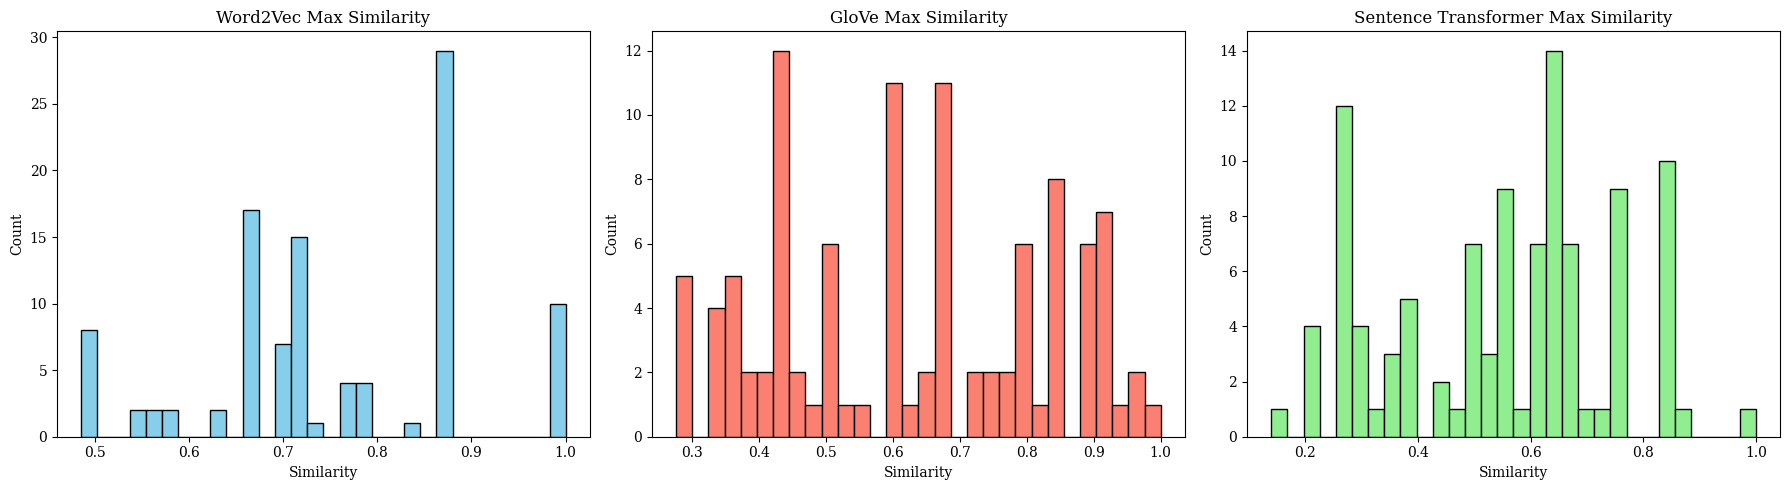

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for Word2Vec similarity
axs[0].hist(candidate_data['word2vec_max_similarity'].dropna(), bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Word2Vec Max Similarity')
axs[0].set_xlabel('Similarity')
axs[0].set_ylabel('Count')

# Histogram for GloVe similarity
axs[1].hist(candidate_data['glove_max_similarity'].dropna(), bins=30, color='salmon', edgecolor='black')
axs[1].set_title('GloVe Max Similarity')
axs[1].set_xlabel('Similarity')
axs[1].set_ylabel('Count')

# Histogram for Sentence Transformer similarity
axs[2].hist(candidate_data['sentence_max_similarity'].dropna(), bins=30, color='lightgreen', edgecolor='black')
axs[2].set_title('Sentence Transformer Max Similarity')
axs[2].set_xlabel('Similarity')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [30]:
def seniority_score(job_title):
    if pd.isnull(job_title):
        return 0.0
    title = job_title
    
    # List of seniority/experience keywords, ordered from most to least senior
    seniority_keywords = [
        ('chief', 1.0), ('svp', 1.0), ('c-level', 1.0), ('executive', 0.95), ('director', 0.9),
        ('head', 0.9), ('principal', 0.85), ('lead', 0.8), ('senior', 0.75), ('sr.', 0.75),
        ('manager', 0.7), ('consultant', 0.65), ('specialist', 0.6), ('mid-level', 0.5),
        ('associate', 0.4), ('junior', 0.2), ('entry', 0.1), ('intern', 0.05), ('student', 0.0)
    ]
    for keyword, score in seniority_keywords:
        if keyword in title:
            return score
    return 0.0

candidate_data['seniority_score'] = candidate_data['job_title_lemmatized'].apply(seniority_score)

In [32]:
candidate_data.head()

,id,job_title,location,connection,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings,glove_embeddings,word2vec_max_similarity,glove_max_similarity,sentence_max_similarity,seniority_score
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56...","[[-0.61878, -0.049302, 0.35098, 0.37847, -0.21...",0.608446,0.600986,0.546717,0.0
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220...","[[-0.70018, 0.053196, -0.20213, -0.3469, -0.12...",0.236671,0.443755,0.240177,0.0
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964...","[[0.042918, 0.90274, -0.14664, 0.12454, 0.0925...",0.903204,0.927182,0.843197,0.0
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00...","[[-0.41355, 0.076012, 0.099178, -0.01195, 0.01...",0.285902,0.509445,0.486340,0.0
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0...","[[0.29924, -0.056401, -0.10924, -0.16313, 0.43...",0.251144,0.329143,0.282052,0.0


In [33]:
import string

def punctuation_penalty(text):
    if pd.isnull(text):
        return 0.0
    # Define unwanted punctuation/symbols (exclude common ones like hyphen, period, comma if desired)
    unwanted = set(string.punctuation) - set(["-", ".", ",", "&", "|", " "])
    count = sum(1 for c in str(text) if c in unwanted)
    # Penalty: ratio of unwanted chars to total length
    total_chars = len(str(text))
    return count / total_chars if total_chars > 0 else 0.0

candidate_data['job_title_punct_penalty'] = candidate_data['job_title_lemmatized'].apply(punctuation_penalty)

In [34]:
candidate_data.head()

,id,job_title,location,connection,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings,glove_embeddings,word2vec_max_similarity,glove_max_similarity,sentence_max_similarity,seniority_score,job_title_punct_penalty
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56...","[[-0.61878, -0.049302, 0.35098, 0.37847, -0.21...",0.608446,0.600986,0.546717,0.0,0.020619
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220...","[[-0.70018, 0.053196, -0.20213, -0.3469, -0.12...",0.236671,0.443755,0.240177,0.0,0.037736
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964...","[[0.042918, 0.90274, -0.14664, 0.12454, 0.0925...",0.903204,0.927182,0.843197,0.0,0.000000
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00...","[[-0.41355, 0.076012, 0.099178, -0.01195, 0.01...",0.285902,0.509445,0.486340,0.0,0.000000
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0...","[[0.29924, -0.056401, -0.10924, -0.16313, 0.43...",0.251144,0.329143,0.282052,0.0,0.000000


In [36]:
from sklearn.cluster import KMeans

# Only use rows with valid similarity_scores
valid_candidates = candidate_data[candidate_data['glove_max_similarity'].notnull()]

# Reshape similarity_scores for KMeans
X = valid_candidates['glove_max_similarity'].values.reshape(-1, 1)

# Choose number of clusters (e.g., 3: low, medium, high similarity)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Assign cluster labels back to the original DataFrame
candidate_data.loc[valid_candidates.index, 'similarity_cluster'] = clusters

candidate_data['similarity_cluster'] = candidate_data['similarity_cluster'].astype('Int64')
candidate_data.head()

,id,job_title,location,connection,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings,glove_embeddings,word2vec_max_similarity,glove_max_similarity,sentence_max_similarity,seniority_score,job_title_punct_penalty,similarity_cluster
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56...","[[-0.61878, -0.049302, 0.35098, 0.37847, -0.21...",0.608446,0.600986,0.546717,0.0,0.020619,1
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220...","[[-0.70018, 0.053196, -0.20213, -0.3469, -0.12...",0.236671,0.443755,0.240177,0.0,0.037736,2
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964...","[[0.042918, 0.90274, -0.14664, 0.12454, 0.0925...",0.903204,0.927182,0.843197,0.0,0.000000,0
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00...","[[-0.41355, 0.076012, 0.099178, -0.01195, 0.01...",0.285902,0.509445,0.486340,0.0,0.000000,2
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0...","[[0.29924, -0.056401, -0.10924, -0.16313, 0.43...",0.251144,0.329143,0.282052,0.0,0.000000,2


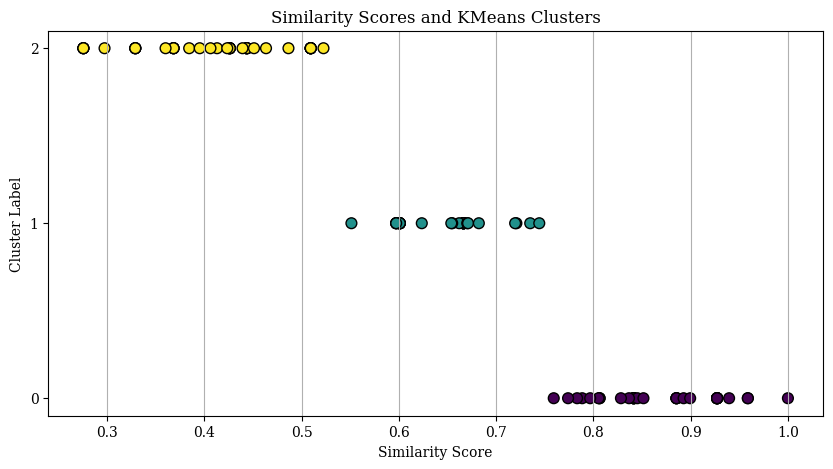

In [37]:
plt.figure(figsize=(10, 5))
plt.scatter(X.flatten(), clusters, c=clusters, cmap='viridis', s=60, edgecolor='k')
plt.xlabel('Similarity Score')
plt.ylabel('Cluster Label')
plt.title('Similarity Scores and KMeans Clusters')
plt.yticks([0, 1, 2])
plt.grid(True, axis='x')
plt.show()

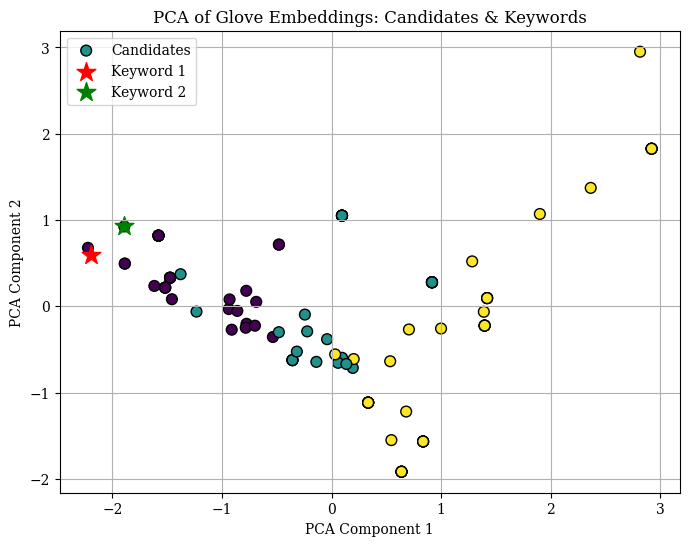

In [84]:
from sklearn.decomposition import PCA

# Prepare embeddings: keyword and all valid candidate entries
keyword_embs = np.vstack([np.mean(emb, axis=0) for emb in glove_keyword_embs if emb.size > 0])
candidate_embs = np.vstack([np.mean(emb, axis=0) for emb in valid_candidates['glove_embeddings']])
all_embs = np.vstack([keyword_embs, candidate_embs])

# Run PCA to reduce to 2D
pca = PCA(n_components=2, random_state=42)
embs_2d = pca.fit_transform(all_embs)

# Plot
plt.figure(figsize=(8, 6))
# Plot candidates, colored by cluster
scatter = plt.scatter(
    embs_2d[2:, 0], embs_2d[2:, 1],
    c=clusters, cmap='viridis', s=60, edgecolor='k', label='Candidates'
)

# Plot keywords
plt.scatter(
    embs_2d[0, 0], embs_2d[0, 1],
    c='red', marker='*', s=200, label='Keyword 1')

plt.scatter(
    embs_2d[1, 0], embs_2d[1, 1],
    c='green', marker='*', s=200, label='Keyword 2')


plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Glove Embeddings: Candidates & Keywords')
plt.legend()
plt.grid(True)
plt.show()

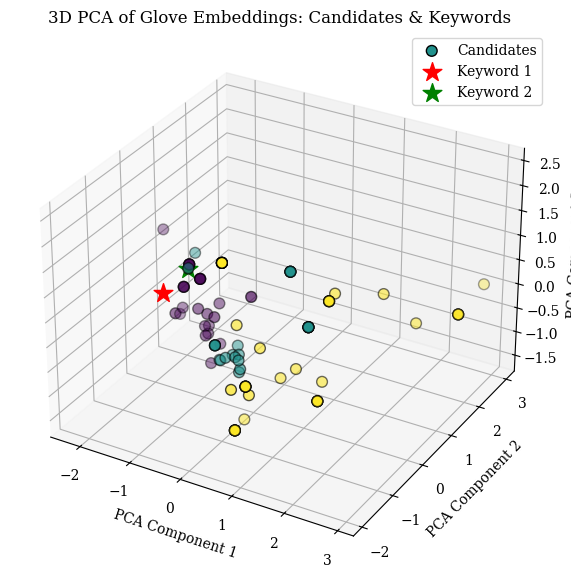

In [86]:
from mpl_toolkits.mplot3d import Axes3D

# Prepare embeddings: keyword and all valid candidate entries
keyword_embs = np.vstack([np.mean(emb, axis=0) for emb in glove_keyword_embs if emb.size > 0])
candidate_embs = np.vstack([np.mean(emb, axis=0) for emb in valid_candidates['glove_embeddings']])
all_embs = np.vstack([keyword_embs, candidate_embs])


# Run PCA to reduce to 3D
pca_3d = PCA(n_components=3, random_state=42)
embs_3d = pca_3d.fit_transform(all_embs)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot candidates, colored by cluster
sc = ax.scatter(
    embs_3d[2:, 0], embs_3d[2:, 1], embs_3d[2:, 2],
    c=clusters, cmap='viridis', s=60, edgecolor='k', label='Candidates'
)
# Plot keyword
ax.scatter(
    embs_3d[0, 0], embs_3d[0, 1], embs_3d[0, 2],
    c='red', marker='*', s=200, label='Keyword 1'
)

ax.scatter(
    embs_3d[1, 0], embs_3d[1, 1], embs_3d[1, 2],
    c='green', marker='*', s=200, label='Keyword 2'
)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D PCA of Glove Embeddings: Candidates & Keywords')
ax.legend()
plt.show()

In [87]:
def experience_score(job_title_lemmatized):
    if pd.isnull(job_title_lemmatized):
        return 0.0
    return 1.0 if 'experience' in job_title_lemmatized.lower() else 0.0

candidate_data['experience_score'] = candidate_data['job_title_lemmatized'].apply(experience_score)

In [88]:
candidate_data.head()

,id,job_title,location,connection,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings,glove_embeddings,word2vec_max_similarity,glove_max_similarity,sentence_max_similarity,seniority_score,job_title_punct_penalty,similarity_cluster,experience_score
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56...","[[-0.61878, -0.049302, 0.35098, 0.37847, -0.21...",0.608446,0.600986,0.546717,0.0,0.020619,1,0.0
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220...","[[-0.70018, 0.053196, -0.20213, -0.3469, -0.12...",0.236671,0.443755,0.240177,0.0,0.037736,2,0.0
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964...","[[0.042918, 0.90274, -0.14664, 0.12454, 0.0925...",0.903204,0.927182,0.843197,0.0,0.000000,0,0.0
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00...","[[-0.41355, 0.076012, 0.099178, -0.01195, 0.01...",0.285902,0.509445,0.486340,0.0,0.000000,2,0.0
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0...","[[0.29924, -0.056401, -0.10924, -0.16313, 0.43...",0.251144,0.329143,0.282052,0.0,0.000000,2,0.0


In [89]:
candidate_data.columns

Index(['id', 'job_title', 'location', 'connection', 'job_title_lemmatized',
       'hr_term', 'word2vec_embeddings', 'sentence_transformer_embeddings',
       'glove_embeddings', 'word2vec_max_similarity', 'glove_max_similarity',
       'sentence_max_similarity', 'seniority_score', 'job_title_punct_penalty',
       'similarity_cluster', 'experience_score'],
      dtype='object')

In [91]:
import openai
from openai import OpenAI

client = openai.OpenAI(api_key="sk-proj-rCY9AX7_FXZkiwZ57f9rrkLGdZQ1AZcvMLjRRCx7g2GsTcHLo8Z-" \
"jpgGxUvT28IPHJpVLsnc3aT3BlbkFJYai_rfEHVOQG_h3jlp-HUUgfBWnGqbsYRjB5-O783bSYdK-ZJIvfuGqM6ngepsg5ceXhWZb_cA")

import json

def extract_location_parts(location):
    """
    Use OpenAI LLM to extract country and city/region from a location string.
    If the country is not present, the LLM will infer it.
    """
    if pd.isnull(location) or not str(location).strip():
        return pd.Series({'country': None, 'city_region': None})

    prompt = (
        f"Given the following location string: '{location}', "
        "extract the country, city and the region separately. "
        "If the country is not explicitly mentioned, infer it based on the city/region or context. "
        "If city is not mentioned, return None for city. "
        "Return your answer as JSON with keys 'country', 'city' and 'region'."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )

        content = response.choices[0].message.content
        # Try to extract JSON from the response
        start = content.find('{')
        end = content.rfind('}') + 1
        json_str = content[start:end]
        result = json.loads(json_str)
        return pd.Series({
            'country': result.get('country', None),
            'city': result.get('city', None),
            'region': result.get('region', None)
        })
    except Exception as e:
        print(f"LLM extraction failed for '{location}': {e}")
        return pd.Series({'country': None, 'city': None, 'region': None})

# Apply to candidate_data
location_features = candidate_data['location'].apply(extract_location_parts)
candidate_data = pd.concat([candidate_data, location_features], axis=1)

In [92]:
candidate_data.head()

,id,job_title,location,connection,job_title_lemmatized,hr_term,word2vec_embeddings,sentence_transformer_embeddings,glove_embeddings,word2vec_max_similarity,glove_max_similarity,sentence_max_similarity,seniority_score,job_title_punct_penalty,similarity_cluster,experience_score,country,city,region,city_region
0,1.0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,2019 c.t . bauer college business graduate ( m...,True,"[[-0.052490234, 0.063964844, -0.07128906, 0.08...","[-0.090280645, 0.03119654, -0.025606174, -3.56...","[[-0.61878, -0.049302, 0.35098, 0.37847, -0.21...",0.608446,0.600986,0.546717,0.0,0.020619,1,0.0,United States,Houston,Texas,NaN
1,2.0,Native English Teacher at EPIK (English Progra...,Kanada,500+,native english teacher epik ( english program ...,False,"[[0.26367188, 0.28125, -0.05493164, -0.1630859...","[-0.03581775, 0.03851505, 0.02888917, -0.01220...","[[-0.70018, 0.053196, -0.20213, -0.3469, -0.12...",0.236671,0.443755,0.240177,0.0,0.037736,2,0.0,Canada,None,Kanada,NaN
2,3.0,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,aspire human resource professional,True,"[[-0.07910156, 0.05908203, 0.16210938, 0.14257...","[-0.08615715, 0.039636217, -0.08475349, 0.0964...","[[0.042918, 0.90274, -0.14664, 0.12454, 0.0925...",0.903204,0.927182,0.843197,0.0,0.000000,0,0.0,United States,Raleigh-Durham,North Carolina Area,NaN
3,4.0,People Development Coordinator at Ryan,"Denton, Texas",500+,people development coordinator ryan,False,"[[0.26367188, -0.019165039, 0.028930664, 0.234...","[-0.106938034, -0.012768716, -0.07286406, 0.00...","[[-0.41355, 0.076012, 0.099178, -0.01195, 0.01...",0.285902,0.509445,0.486340,0.0,0.000000,2,0.0,United States,Denton,Texas,NaN
4,5.0,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,advisory board member celal bayar university,False,"[[-0.088378906, -0.17773438, 0.1953125, -0.072...","[-0.08322134, 0.016502693, -0.0073081846, -0.0...","[[0.29924, -0.056401, -0.10924, -0.16313, 0.43...",0.251144,0.329143,0.282052,0.0,0.000000,2,0.0,Türkiye,İzmir,None,NaN


In [93]:
def connection_score(connection):
    """
    Score connection count between 0 and 1, linearly from 0 to 500+.
    Accepts values like '85', '500+', etc.
    """
    if pd.isnull(connection):
        return 0.0
    try:
        # Handle '500+' and similar
        if isinstance(connection, str) and '500' in connection:
            return 1.0
        # Try to extract numeric value
        num = int(''.join(filter(str.isdigit, str(connection))))
        score = min(num, 500) / 500.0
        return score
    except Exception:
        return 0.0

candidate_data['connection_score'] = candidate_data['connection'].apply(connection_score)

In [96]:
candidate_data.drop(['city_region'], axis=1, inplace=True)

In [94]:
candidate_data['id'] = candidate_data['id'].astype('Int64')

In [97]:
candidate_data.to_csv('extracted_features_candidate_data_ver2.csv', index=False)